# Imports

In [1]:
!pip install nltk rouge_score -q

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding ,GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout


from sklearn.model_selection import train_test_split
import pickle

# Load Datasets

In [23]:
with open('/kaggle/input/parallel-corpus-for-english-urdu-language/Dataset/english-corpus.txt', 'r',encoding="utf8") as file:
    english_lines = file.readlines()
    
with open('/kaggle/input/parallel-corpus-for-english-urdu-language/Dataset/urdu-corpus.txt', 'r',encoding="utf8") as file:
    urdu_lines = file.readlines()
    
df = pd.DataFrame({'English': english_lines, 'Urdu': urdu_lines})

df['English'] = df['English'].str.strip()
df['Urdu'] = df['Urdu'].str.strip()

df.head()

,English,Urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔


In [25]:
eng = df['English']
urdu = df['Urdu']

# Data Preprocessing

In [29]:
# Tokenizing Urdu sentences
urdu_tokenizer = Tokenizer()
urdu_tokenizer.fit_on_texts(df['Urdu'])
tokenized_urdu_sentences = urdu_tokenizer.texts_to_sequences(df['Urdu'])

# Tokenizing English sentences
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(df['English'])
tokenized_english_sentences = english_tokenizer.texts_to_sequences(df['English'])


# Padding Urdu sentences
preproc_urdu_sentences = pad_sequences(tokenized_urdu_sentences, maxlen=50, padding='post')

# Padding English sentences
preproc_english_sentences = pad_sequences(tokenized_english_sentences, maxlen=50, padding='post')

In [30]:
df['English'][:5]

0     is zain your nephew
1    i wish youd trust me
2        did he touch you
3        its part of life
4          zain isnt ugly
Name: English, dtype: object

In [31]:

preproc_english_sentences[:5]

array([[   2,    4,   22, 2336,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   1,  222,  689,  274,   12,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  30,    6,  478,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [32]:
# Defining model parameters
learning_rate = 0.001
# input_shape = preproc_english_sentences.shape
# output_sequence_length = preproc_urdu_sentences.shape[1]
urdu_vocab_size = len(urdu_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1

# Model Building And Training

In [33]:
# Creating the model
model = Sequential()
model.add(Embedding(english_vocab_size, 256))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(TimeDistributed(Dense(1024, activation='leaky_relu')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(urdu_vocab_size, activation='softmax')))

# Compiling the model
model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(learning_rate),
              metrics=['accuracy'])

# Adding Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the model with Early Stopping
history = model.fit(preproc_english_sentences, preproc_urdu_sentences, 
                    batch_size=64, 
                    epochs=100, 
                    validation_split=0.3, 
                    callbacks=[early_stopping])

Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.8814 - loss: 1.3183 - val_accuracy: 0.9147 - val_loss: 0.5679
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9150 - loss: 0.5469 - val_accuracy: 0.9185 - val_loss: 0.5157
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.9202 - loss: 0.4859 - val_accuracy: 0.9235 - val_loss: 0.4733
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9249 - loss: 0.4308 - val_accuracy: 0.9274 - val_loss: 0.4321
Epoch 5/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9298 - loss: 0.3784 - val_accuracy: 0.9312 - val_loss: 0.4034
Epoch 6/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9350 - loss: 0.3286 - val_accuracy: 0.9336 - val_loss: 0.3844
Epoch 7/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9385 - loss: 0.2943 - val_accuracy: 0.9357 - val_loss: 0.3711
Epoch 8/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9427 - loss: 0

# Evaluation

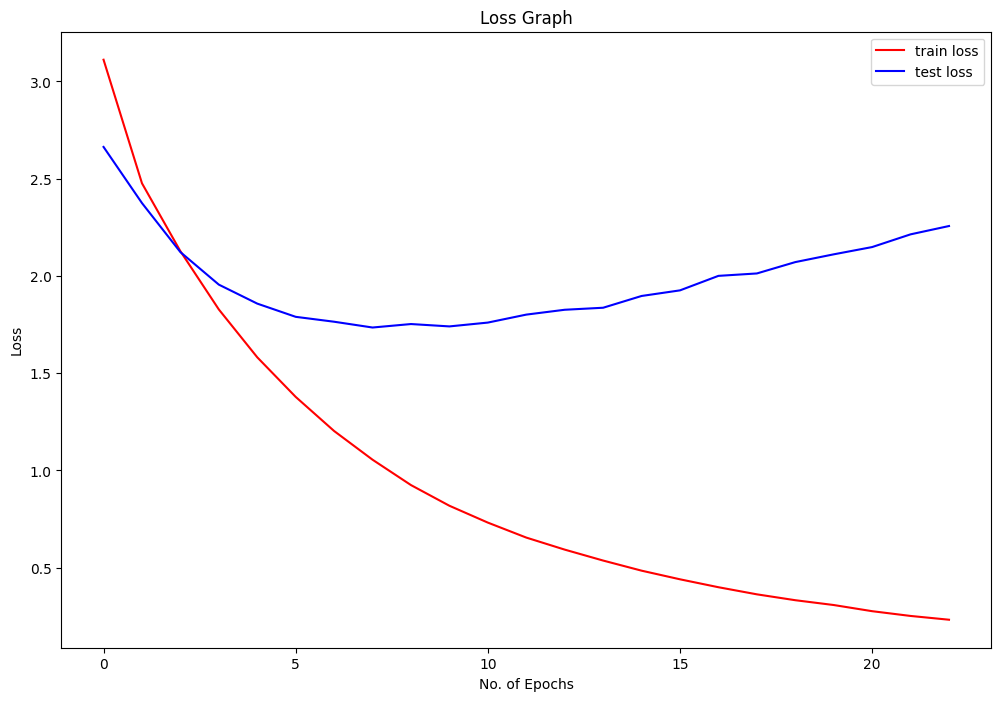

In [12]:

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

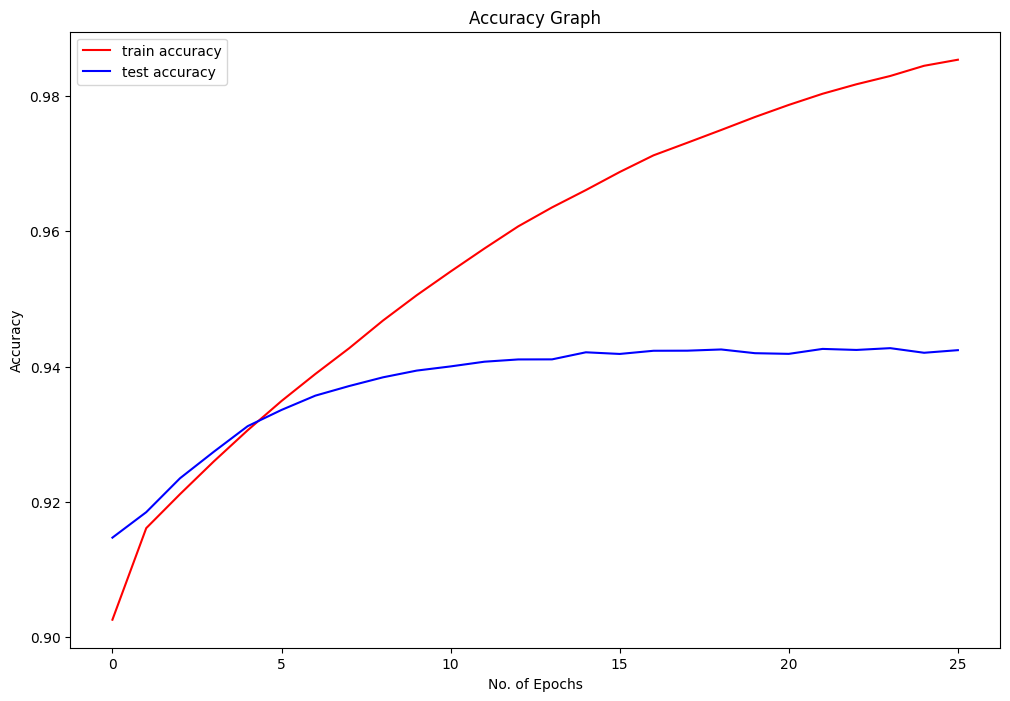

In [34]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [35]:
# Saving the model
model.save('english_to_urdu_translator_final.h5')

pickle.dump(english_tokenizer,open("english_tokenizer.pkl",'wb'))
pickle.dump(urdu_tokenizer,open("urdu_tokenizer.pkl",'wb'))

# Real Time Translation System

In [46]:
# Load the trained model
model = load_model('english_to_urdu_translator_final.h5')

# Load tokenizers
with open('english_tokenizer.pkl', 'rb') as file:
    english_tokenizer = pickle.load(file)

with open('urdu_tokenizer.pkl', 'rb') as file:
    urdu_tokenizer = pickle.load(file)

# Reverse mapping for Urdu tokenizer (index to word)
urdu_index_to_word = {index: word for word, index in urdu_tokenizer.word_index.items()}

def translate_sentences(sentences):
    # Tokenize input sentences
    sequences = english_tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=50, padding='post')
    
    # Predict Urdu sentences
    predictions = model.predict(padded_sequences)
    
    translated_sentences = []
    for prediction in predictions:
        predicted_words = [urdu_index_to_word.get(np.argmax(word_vec), '') for word_vec in prediction]
        translated_sentence = ' '.join(predicted_words).strip()
        translated_sentences.append(translated_sentence)
    
    return translated_sentences
    
# Sample 10 English sentences
english_sentences = [
    "is zain your nephew",
    "i wish youd trust me",
    "did he touch you",
    "its part of life",
    "zain isnt ugly",
    "i am in a hurry today",
    "take this medicine",
    "this is the case",
    "zains tipsy",
    "i am not angry"
]

# Translate and print results
urdu_translations = translate_sentences(english_sentences)

for eng, urdu in zip(english_sentences, urdu_translations):
    print(f"English: {eng}\nUrdu: {urdu}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
English: is zain your nephew
Urdu: کیا آپ بھتیجا ہے

English: i wish youd trust me
Urdu: کاش آپ پر پر بھروسہ بھروسہ

English: did he touch you
Urdu: کیا اس نے آپ کو مارا؟

English: its part of life
Urdu: اس کی کا زندگی

English: zain isnt ugly
Urdu: زین بدصورت نہیں ہے

English: i am in a hurry today
Urdu: میں جلد میں ہوں

English: take this medicine
Urdu: اس شال لے

English: this is the case
Urdu: یہ معاملہ ہے

English: zains tipsy
Urdu: زان شاندار

English: i am not angry
Urdu: میں ناراض نہیں ہوں

